In [73]:
import numpy as np
from PIL import Image
import time, re, os, sys
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import pdist,squareform
from array2gif import write_gif

#from util import *


In [74]:
GIF_path = './GIF'
colormap= np.random.choice(range(256),size=(100,3))


In [75]:
def openImage(path):
	image = cv2.imread(path)
	H, W, C = image.shape
	image_flat = np.zeros((W * H, C))
	for h in range(H):
		image_flat[h * W:(h + 1) * W] = image[h]

	return image_flat,H,W

In [76]:
def precomputed_kernel(X, gamma_s, gamma_c):
    n=len(X)
    # S(x) spacial information
    S=np.zeros((n,2))
    for i in range(n):
        S[i]=[i//100,i%100]
    print(pdist(S,'sqeuclidean').shape)
    K=squareform(np.exp(-gamma_s*pdist(S,'sqeuclidean')))*squareform(np.exp(-gamma_c*pdist(X,'sqeuclidean')))
    print(K.shape)
    return K


In [77]:
def visualize(C,k,H,W):
    '''
    @param C: (10000) belonging classes ndarray
    @param k: #clusters
    @param H: image_H
    @param W: image_W
    @return : (H,W,3) ndarray
    '''
    colors= colormap[:k,:]
    res=np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            res[h,w,:] = colors[C[h*W+w]]

    return res.astype(np.uint8)

In [78]:
def kmeans(CLUSTER_NUM, Gram, H, W, init='None'):
    Cluster = np.zeros((CLUSTER_NUM, Gram.shape[1]))
    if init == 'random':
        random_pick=np.random.randint(low=0,high=Gram.shape[0],size=CLUSTER_NUM)
        Cluster = Gram[random_pick,:]
    if init == 'gaussian':
        X_mean=np.mean(Gram,axis=0)
        X_std=np.std(Gram,axis=0)
        for c in range(Gram.shape[1]):
            Cluster[:,c]=np.random.normal(X_mean[c],X_std[c],size=CLUSTER_NUM)
      
    # kmeans++ init
    
    Cluster[0]=Gram[np.random.randint(low=0,high=Gram.shape[0],size=1),:]
    for c in range(1,CLUSTER_NUM):
            Dist=np.zeros((len(Gram),c))
            for i in range(len(Gram)):
                for j in range(c):
                    Dist[i,j]=np.sqrt(np.sum((Gram[i]-Cluster[j])**2))
            Dist_min=np.min(Dist,axis=1)
            sum=np.sum(Dist_min)*np.random.rand()
            for i in range(len(Gram)):
                sum-=Dist_min[i]
                if sum<=0:
                    Cluster[c]=Gram[i]
                    break
    # kmeans++
    diff = 1e9
    eps = 1e-9
    count = 1
    # Classes of each Xi
    C=np.zeros(len(Gram),dtype=np.uint8)
    segments=[]
    while diff > eps:
        # E-step
        for i in range(len(Gram)):
            dist=[]
            for j in range(CLUSTER_NUM):
                dist.append(np.sqrt(np.sum((Gram[i]-Cluster[j])**2)))
            C[i]=np.argmin(dist)
        
        #M-step
        New_Mean=np.zeros(Cluster.shape)
        for i in range(CLUSTER_NUM):
            belong=np.argwhere(C==i).reshape(-1)
            for j in belong:
                New_Mean[i]=New_Mean[i]+Gram[j]
            if len(belong)>0:
                New_Mean[i]=New_Mean[i]/len(belong)

        diff = np.sum((New_Mean - Cluster)**2)
        Cluster=New_Mean
        # visualize
        segment = visualize(C, CLUSTER_NUM, H, W)
        segments.append(segment)
        print('iteration {}'.format(count))
        for i in range(CLUSTER_NUM):
            print('k={}: {}'.format(i + 1, np.count_nonzero(C == i)))
        print('diff {}'.format(diff))
        print('-------------------')
        cv2.imshow('', segment)
        cv2.waitKey(1)
    return C, segments


In [79]:
def plot_eigenvector(xs,ys,zs,C):
    '''
    only for 3-dim datas
    @param xs: (#datapoint) ndarray
    @param ys: (#datapoint) ndarray
    @param zs: (#datapoint) ndarray
    @param C: (#datapoint) ndarray, belonging class
    '''
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    markers=['o','^','s']
    for marker,i in zip(markers,np.arange(3)):
        ax.scatter(xs[C==i],ys[C==i],zs[C==i],marker=marker)

    ax.set_xlabel('eigenvector 1st dim')
    ax.set_ylabel('eigenvector 2nd dim')
    ax.set_zlabel('eigenvector 3rd dim')
    plt.show()

In [80]:
def spectral_clustering(path, cut):
    image_flat,H,Width=openImage(path)
    gamma_s=0.001
    gamma_c=0.001
    k_means_initType='k_means_plusplus'
    k=3  # k clusters
    filename = path.split('.')[0] + '_' + cut + '.gif'
    gif_path = os.path.join(GIF_path, filename)
    W=precomputed_kernel(image_flat,gamma_s,gamma_c)
    # degree matrix
    D=np.diag(np.sum(W,axis=1))
    L=D-W
    if cut == 'ratio':
        eigenvalue=np.load('{}_eigenvalue_{:.3f}_{:.3f}_unnormalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
        eigenvector=np.load('{}_eigenvector_{:.3f}_{:.3f}_unnormalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
    if cut == 'normalized':
        D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
        L_sym=D_inverse_square_root@L@D_inverse_square_root
        eigenvalue=np.load('{}_eigenvalue_{:.3f}_{:.3f}_normalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
        eigenvector=np.load('{}_eigenvector_{:.3f}_{:.3f}_normalized.npy'.format(path.split('.')[0],gamma_s,gamma_c))
    sort_index = np.argsort(eigenvalue)
    U = eigenvector[:, sort_index[1:1+k]]
    if cut == 'normalized':
        sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
        U_norm=U/sums
        C, segments = kmeans(k, U_norm, H, Width, init='gaussian')
    else:
        C, segments = kmeans(k, U, H, Width, init='gaussian')
    # save_gif
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1, 0, 2)
    write_gif(segments, gif_path, fps=2)
    if k==3:
        plot_eigenvector(U[:,0],U[:,1],U[:,2],C)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print('done')


(49995000,)
(10000, 10000)
iteration 1
k=1: 2301
k=2: 5176
k=3: 2523
diff 0.6798314006097707
-------------------
iteration 1
k=1: 2211
k=2: 5254
k=3: 2535
diff 0.007911759035576785
-------------------
iteration 1
k=1: 2172
k=2: 5278
k=3: 2550
diff 0.0007743227775960129
-------------------
iteration 1
k=1: 2160
k=2: 5289
k=3: 2551
diff 8.901543486012774e-05
-------------------
iteration 1
k=1: 2157
k=2: 5292
k=3: 2551
diff 5.971883428188802e-06
-------------------
iteration 1
k=1: 2157
k=2: 5293
k=3: 2550
diff 2.0202162968407293e-07
-------------------
iteration 1
k=1: 2157
k=2: 5293
k=3: 2550
diff 0.0
-------------------


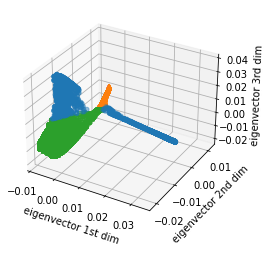

done
(49995000,)
(10000, 10000)
iteration 1
k=1: 3868
k=2: 2610
k=3: 3522
diff 0.7895125752130813
-------------------
iteration 1
k=1: 3853
k=2: 2262
k=3: 3885
diff 0.030942160017161734
-------------------
iteration 1
k=1: 3874
k=2: 2210
k=3: 3916
diff 0.0012114825756469863
-------------------
iteration 1
k=1: 3889
k=2: 2210
k=3: 3901
diff 0.00010093786343774583
-------------------
iteration 1
k=1: 3895
k=2: 2213
k=3: 3892
diff 1.3934281621775771e-05
-------------------
iteration 1
k=1: 3898
k=2: 2215
k=3: 3887
diff 4.65690175967748e-06
-------------------
iteration 1
k=1: 3899
k=2: 2216
k=3: 3885
diff 8.333558831574687e-07
-------------------
iteration 1
k=1: 3900
k=2: 2216
k=3: 3884
diff 1.3591383553686033e-07
-------------------
iteration 1
k=1: 3900
k=2: 2216
k=3: 3884
diff 0.0
-------------------


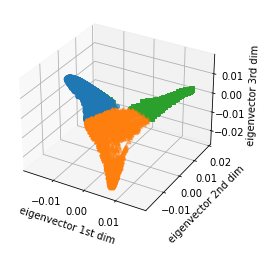

done


In [81]:
#spectral_clustering('image1.png', 'ratio')
spectral_clustering('image1.png', 'normalized')
#spectral_clustering('image2.png', 'ratio')
spectral_clustering('image2.png', 'normalized')
